## Codebook evaluation tutorial

In this notebook, we demonstrate how we can evaluate the performance of a codebook with respect to a specified coding problem, noisy channel model, and optimality metric.

In [1]:
import os
import logging

import matplotlib.pylab as plt
import numpy as np
import torch

from mighty_codes import consts
from mighty_codes import metric_utils
from mighty_codes import plot_utils
from mighty_codes import experiments

from mighty_codes.torch_utils import \
    to_np, \
    to_torch, \
    to_one_hot_encoded

from mighty_codes.experiments import \
    ChannelModelSpecification

log_info = print

device = torch.device("cuda:0")
dtype = torch.float32

## Configuration

In [2]:
params = {
    'experiment_prefix': 'test',
    'channel_model': 'channel_bac_merfish',
    'code_length': 14,
    'min_symbol_weight_s': [1, 1],
    'max_symbol_weight_s': [13, 13],
    'n_types': 40,
    'source_nonuniformity': 100.,
}

## Setup the experiment

In [4]:
# fetch all channel models
all_channel_model_specs_dict = dict()
for k, v in experiments.__dict__.items():
    if isinstance(v, ChannelModelSpecification):
        all_channel_model_specs_dict[k] = v

log_info('Available channel models:\n')
for k, v in all_channel_model_specs_dict.items():
    log_info(k)
log_info()

# specify channel model
channel_spec = all_channel_model_specs_dict[params['channel_model']]
channel_model = channel_spec.channel_model.to(device).type(dtype)
log_info(f"Selected channel model: {params['channel_model']}")

# generate the experiment specifiation
experiment_spec = experiments.generate_experiment_spec(
    name_prefix=params['experiment_prefix'],
    min_symbol_weight_s=params['min_symbol_weight_s'],
    max_symbol_weight_s=params['max_symbol_weight_s'],
    n_symbols=channel_model.n_symbols,
    code_length=params['code_length'],
    n_types=params['n_types'],
    source_nonuniformity=params['source_nonuniformity'])

# generate problem spec
problem_spec = experiments.SingleEntityCodingProblemSpecification(
    experiment_spec=experiment_spec,
    channel_spec=channel_spec)

Available channel models:

channel_bsc_10
channel_bac_merfish
channel_gaussian_merfish

Selected channel model: channel_bac_merfish


## Try out a codebook!

Codebooks are always represented as 4-dim one-hot-encoded tensors with shape `(batch_size, n_types, code_length, n_symbols)`

- For a single codebook, batch_size = 1
- For binary channels, n_symbols = 2


In [5]:
from mighty_codes.sa_bac.main import BatchedBinaryCodebookManipulator

batch_size = 10

# we use a helper class ...
bbcm = BatchedBinaryCodebookManipulator(
    code_length=params['code_length'],
    n_types=params['n_types'],
    min_hamming_weight=params['min_symbol_weight_s'][1],
    max_hamming_weight=params['max_symbol_weight_s'][1],
    perturb_max_neighbor_hop_range=1,  # irrelevant here
    perturb_max_hamming_distance=1,  # irrelevant here
    perturb_max_hamming_weight_change=1,  # irrelevant here,
    device=device,
    dtype=dtype)

# ... to generate random binary codebooks ...
random_codebook_btl = bbcm.get_explicit_codebook_btl(
        bbcm.generate_random_state_batch(batch_size=batch_size)).to(torch.long)

# ... and convert them to one-hot-encoded
random_codebook_btls = torch.eye(2, device=device, dtype=torch.long)[random_codebook_btl, :]
log_info(random_codebook_btls.shape)
log_info(random_codebook_btls.dtype)

torch.Size([10, 40, 14, 2])
torch.int64


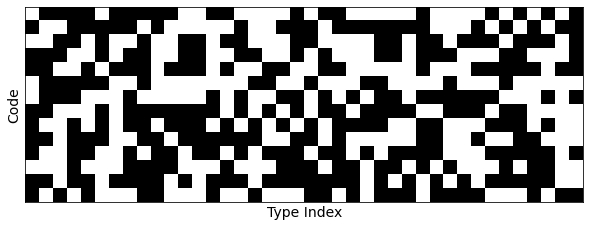

In [6]:
# let's plot the first codebook in the batch
i_batch = 0

fig = plt.figure(figsize=(10, 4))
ax = plt.gca()

codebook_tl_np = random_codebook_btls[i_batch, :, :, 1].cpu().numpy()
ax.imshow(codebook_tl_np.T, cmap=plt.cm.Greys_r)
ax.set_xlabel('Type Index')
ax.set_ylabel('Code')
ax.set_xticks([]);
ax.set_yticks([]);

Now, let's evaluate these codebooks

In [7]:
# get the decoding confusion matrix
decoder_output_dict = channel_model.get_weighted_confusion_matrix(
    codebook_btls=random_codebook_btls,
    pi_bt=to_torch(experiment_spec.pi_t, device=device, dtype=dtype).expand(
        [batch_size, experiment_spec.n_types]),
    decoder_type='posterior_sampled',
    split_size=1  # how many codebooks to decode in parallel
)
        
# get metrics dict
metrics_dict = metric_utils.get_metrics_dict_from_decoder_output_dict(
    decoder_output_dict=decoder_output_dict,
    metrics_dict_type='basic')

- `decoder_output_dict` contains a weighted confusion matrix, which is the joint probability `prob(source=t, target=t')`
- `metrics_dict` contains various metrics such as TPR, FDR, etc.

In [8]:
decoder_output_dict.keys()

dict_keys(['decoder_type', 'weighted_confusion_matrix_btt'])

In [9]:
metrics_dict.keys()

dict_keys(['tpr_bt', 'fdr_bt', 'fpr_bt', 'acc_bt', 'f_1_bt'])

Finally, let us visualize the codebook together with the metrics

Text(0, 0.5, 'FDR')

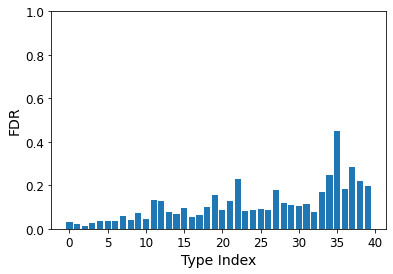

In [10]:
i_batch = 0
fdr_t_np = metrics_dict['fdr_bt'][i_batch, :].cpu().numpy()

fig = plt.figure()
ax = plt.gca()

ax.bar(np.arange(params['n_types']), fdr_t_np)
ax.set_ylim((0, 1))
ax.set_xlabel('Type Index')
ax.set_ylabel('FDR')

In addition to BAC, MightyCodes provides Gaussian channels. For each channel, we have implemented two different decoder types, `posterior_sampled` and `map_reject`. Let us finish this tutorial with swapping the `posterior_sampled` decoder with the `map_reject` decoder:

In [11]:
# get the decoding confusion matrix
decoder_output_dict = channel_model.get_weighted_confusion_matrix(
    codebook_btls=random_codebook_btls,
    pi_bt=to_torch(experiment_spec.pi_t, device=device, dtype=dtype).expand(
        [batch_size, experiment_spec.n_types]),
    decoder_type='map_reject',
    delta_q_max=1e-2,  # "1 - delta_q_max" is the largest posterior concentration considered for acceptance
    split_size=1,  # how many codebooks to decode in parallel?
    n_map_reject_thresholds=50,  # how many different posterior concentration rejection thresholds to evaluate for each codebook?
)
        
# get metrics dict
metrics_dict = metric_utils.get_metrics_dict_from_decoder_output_dict(
    decoder_output_dict=decoder_output_dict,
    metrics_dict_type='auc',
    max_rej_ratio=0.5,  # maximum rejection rate to consider in making rejection curves
    interpolation_method='lo',  # strategy to interpolate rejection curves
)

In [12]:
print(decoder_output_dict.keys())

dict_keys(['decoder_type', 'weighted_confusion_matrix_bqtu', 'log_prob_map_thresholds_q', 'num_all_bt', 'num_rej_bqt'])


In [13]:
print(metrics_dict.keys())

dict_keys(['tpr_bqt', 'fdr_bqt', 'fpr_bqt', 'acc_bqt', 'f_1_bqt', 'rej_bqt', 'normalized_auc_f_1_rej_bt', 'clamped_rej_bqt', 'clamped_f_1_bqt'])


Let us plot the FDR for several rejection thresholds:

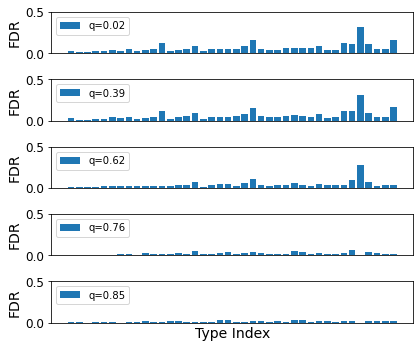

In [14]:
i_batch = 0
i_q_list = [0, 5, 10, 15, 20]

n_q = len(i_q_list)
fig, axs = plt.subplots(nrows=n_q, figsize=(6, 1 * n_q))
for i_q, ax in zip(i_q_list, axs):
    fdr_t_np = metrics_dict['fdr_bqt'][i_batch, i_q, :].cpu().numpy()
    q_threshold = np.exp(decoder_output_dict['log_prob_map_thresholds_q'][i_q].item())
    ax.bar(np.arange(params['n_types']), fdr_t_np, label=f'q={q_threshold:.2f}')
    ax.set_ylim((0, 0.5))
    ax.set_xticks([])
    ax.set_ylabel('FDR')
    ax.legend(fontsize=10, loc='upper left')
ax.set_xlabel('Type Index')
ax.set_ylabel('FDR')
fig.tight_layout()

Note that as the acceptance threshold (posterior concentration $q$) increases, FDR drops, as expected. Let's plot the rejection rate:

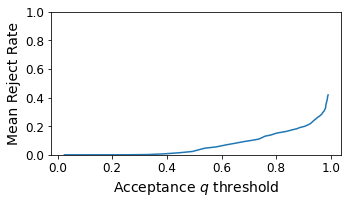

In [15]:
fig = plt.figure(figsize=(5, 3))
ax = plt.gca()

q_threshold_np = decoder_output_dict['log_prob_map_thresholds_q'].exp().cpu().numpy()
mean_reject_rate_np = metrics_dict['rej_bqt'][i_batch, :, :].mean(-1).cpu().numpy()

ax.plot(q_threshold_np, mean_reject_rate_np)
ax.set_ylim((0, 1))
ax.set_ylabel('Mean Reject Rate')
ax.set_xlabel('Acceptance $q$ threshold')
fig.tight_layout()